In [212]:
import sqlite3
import pandas
import matplotlib.pyplot as plt
import numpy as np
import statistics

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Part 1: Wrangling
### Problem 1 (8 pts)
Using SQL compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).

Include the SQL code you used to create this relation in your writeup. Describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data. One note, for SQL you have to be mindful of integer vs. float division.

I mentioned in the lectures that some folks find Pandas simpler to use than SQL, and that's true. However, there are cases where SQL is unavoidable. If the data is already stored in a database, you'd need to know at least enough SQL to get the data out.

In [49]:
salary_query = "SELECT teamID, yearID, sum(salary)/1000 as total_payroll_thousands FROM Salaries GROUP BY teamID, yearID"
team_salaries = pandas.read_sql(salary_query, conn)

team_query = "SELECT (W*100.0/G) as win_p, franchID, W, G, teamID, yearID FROM Teams GROUP BY teamID, yearID"
team_table = pandas.read_sql(team_query, conn)

mean_query = "SELECT yearID, sum(salary)/count(salary) as mean_salary FROM Salaries GROUP BY yearID"
mean_table = pandas.read_sql(mean_query, conn)

result = pandas.merge(team_salaries, team_table, how='outer', on=['teamID', 'yearID'])
result = pandas.merge(result, mean_table, how='outer', on=['yearID'])
result

,teamID,yearID,total_payroll_thousands,win_p,franchID,W,G,mean_salary
0,ATL,1985,14807.000,40.740741,ATL,66.0,162.0,476299.447273
1,BAL,1985,11560.712,51.552795,BAL,83.0,161.0,476299.447273
2,BOS,1985,10897.560,49.693252,BOS,81.0,163.0,476299.447273
3,CAL,1985,14427.894,55.555556,ANA,90.0,162.0,476299.447273
4,CHA,1985,9846.178,52.147239,CHW,85.0,163.0,476299.447273
...,...,...,...,...,...,...,...,...
2772,CHN,1878,NaN,49.180328,CHC,30.0,61.0,NaN
2773,CN1,1878,NaN,60.655738,CNR,37.0,61.0,NaN
2774,IN1,1878,NaN,38.095238,IBL,24.0,63.0,NaN
2775,ML2,1878,NaN,24.590164,MLG,15.0,61.0,NaN


# Part 2: Exploratory Data Analysis
## Payroll Distribution
### Problem 2 (8 pts)
Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014).
### Question 1 (9 pts)
What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

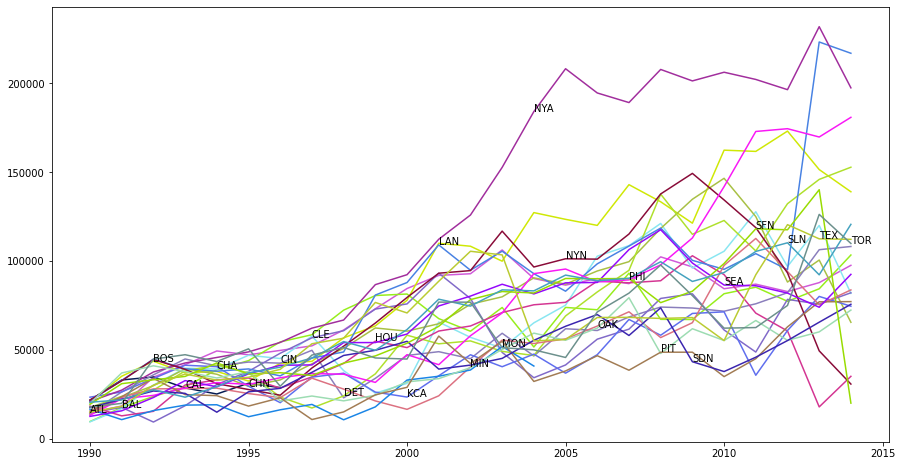

In [43]:
result.sort_values("yearID", ascending=True)
temp = result[result['yearID'] > 1989]
temp = temp[temp['yearID'] < 2015]
teams = temp['teamID'].drop_duplicates()
temp = temp[['yearID', 'teamID', 'total_payroll_thousands']]
temp = temp.set_index('teamID')

year = 1990
plt.figure(figsize=[15,8])
for team in teams:
    t = temp.loc[lambda temp: temp.yearID == year, :]
    if team in t.index:
        num = t.loc[team, 'total_payroll_thousands']
        plt.annotate(team, xy=(year, num))
        plt.plot(temp.loc[team, 'yearID'], temp.loc[team, 'total_payroll_thousands'], color=numpy.random.rand(3,))
        if (year < 2014):
            year += 1
        else:
            year = 1990

1. The overall trend of the industry is increasing, with only one or two drop back to the original. 
    (And despite that they drop back to the basic, they've increaced once.) 
2. The gap between teams are getting larger.
3. There seems to be a peak around 2013 when most teams reaches its top.

### Problem 3 (8 pts)
Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

Text(0, 0.5, 'mean salary (thousands)')

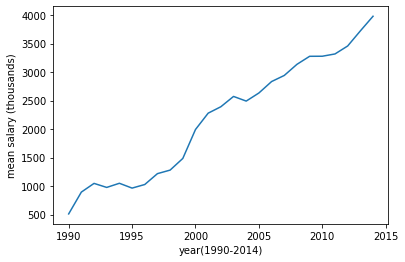

In [56]:
result.sort_values("mean_salary", ascending=True)
temp = result[result['yearID'] > 1989]
temp = temp[temp['yearID'] < 2015]
teams = temp['teamID'].drop_duplicates()
plt.plot(temp['yearID'], temp['mean_salary']/1000)
plt.xlabel('year(1990-2014)')
plt.ylabel('mean salary (thousands)')

## Correlation between payroll and winning percentage
### Problem 4 (8 pts)
Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's polyfit) in each scatter plot to ease interpretation.

In [165]:
payroll_query = "SELECT teamID, yearID, sum(salary)/count(salary) as mean_payroll FROM Salaries GROUP BY teamID, yearID"
payroll_table = pandas.read_sql(payroll_query, conn)

winp_query = "SELECT teamID, yearID, (W*100)/G as win_p FROM Teams GROUP BY teamID, yearID"
winp_table = pandas.read_sql(winp_query, conn)

table = pandas.merge(payroll_table, winp_table, how='outer', on=['yearID', 'teamID'])

bins =[1989, 1994, 1999, 2004, 2009, 2014]
periods = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']
categories = pandas.cut(table['yearID'], bins, labels=periods)
table['categories'] = categories
tables = table.groupby('categories')

period1 = tables.get_group('1990-1994')
period2 = tables.get_group('1995-1999')
period3 = tables.get_group('2000-2004')
period4 = tables.get_group('2005-2009')
period5 = tables.get_group('2010-2014')

Text(0.5, 1.0, 'Winning percentage vs. Mean payroll (1990-1994)')

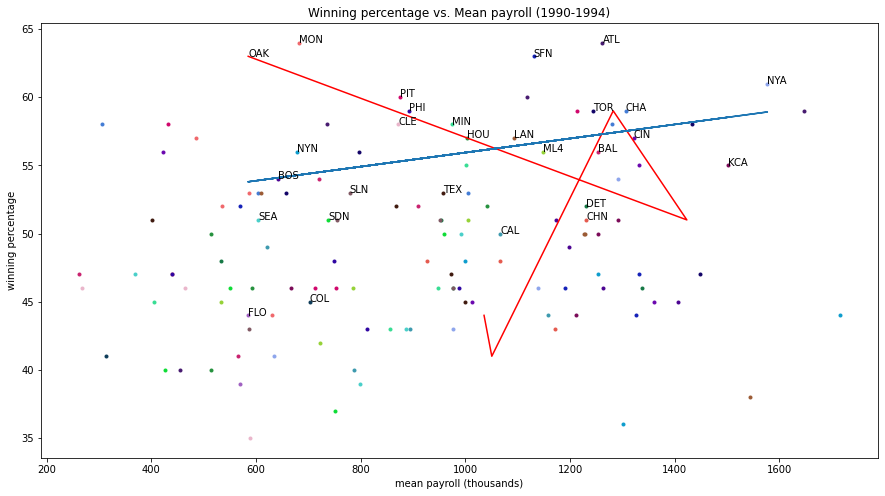

In [160]:
teams = period1['teamID'].drop_duplicates()
temp = period1[['teamID', 'win_p', 'mean_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period1.loc[lambda period1: period1.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['mean_payroll']/1000, row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['mean_payroll']/1000])
    y = np.append(y, [row['win_p']])

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('mean payroll (thousands)')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Mean payroll (1990-1994)')

Text(0.5, 1.0, 'Winning percentage vs. Mean payroll (1995-1999)')

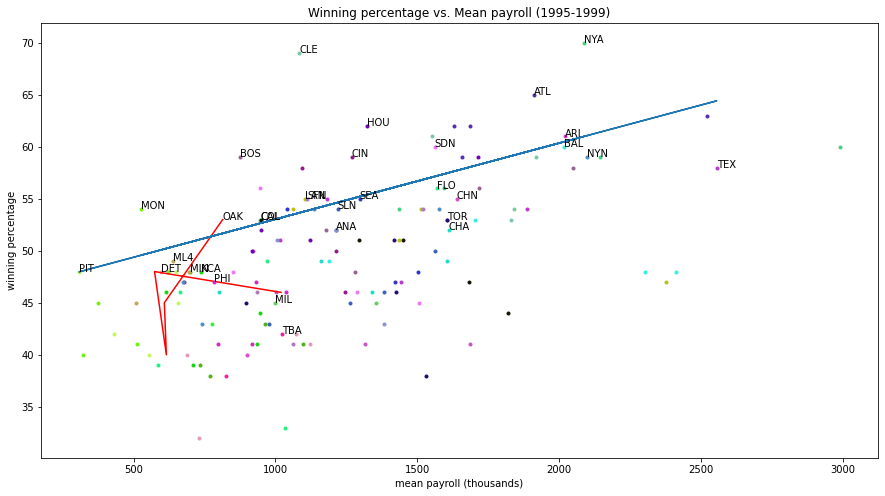

In [161]:
teams = period2['teamID'].drop_duplicates()
temp = period2[['teamID', 'win_p', 'mean_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period2.loc[lambda period2: period2.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['mean_payroll']/1000, row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['mean_payroll']/1000])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('mean payroll (thousands)')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Mean payroll (1995-1999)')

Text(0.5, 1.0, 'Winning percentage vs. Mean payroll (2000-2004)')

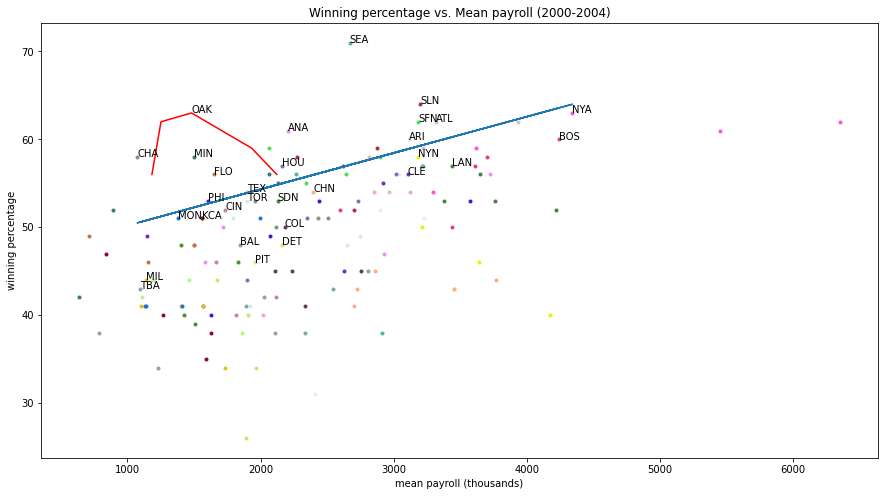

In [162]:
teams = period3['teamID'].drop_duplicates()
temp = period3[['teamID', 'win_p', 'mean_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period3.loc[lambda period1: period1.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['mean_payroll']/1000, row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['mean_payroll']/1000])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('mean payroll (thousands)')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Mean payroll (2000-2004)')

Text(0.5, 1.0, 'Winning percentage vs. Mean payroll (2005-2009)')

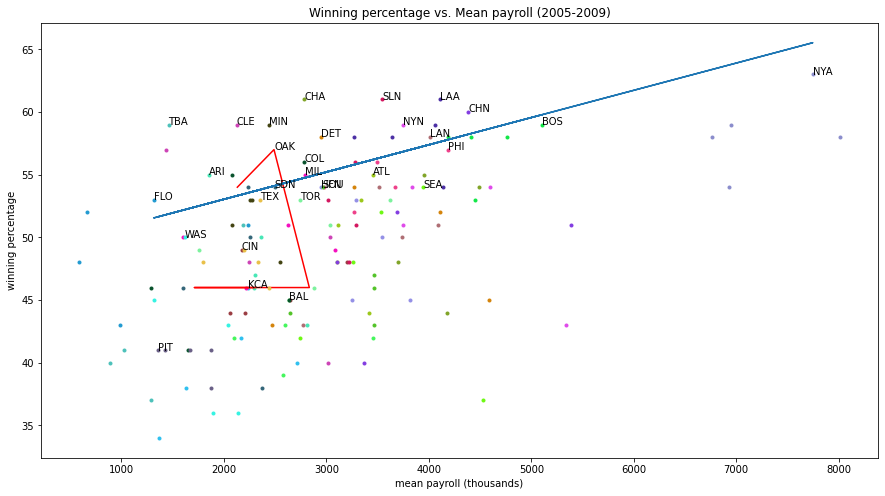

In [163]:
teams = period4['teamID'].drop_duplicates()
temp = period4[['teamID', 'win_p', 'mean_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period4.loc[lambda period4: period4.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['mean_payroll']/1000, row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['mean_payroll']/1000])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('mean payroll (thousands)')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Mean payroll (2005-2009)')

Text(0.5, 1.0, 'Winning percentage vs. Mean payroll (2010-2014)')

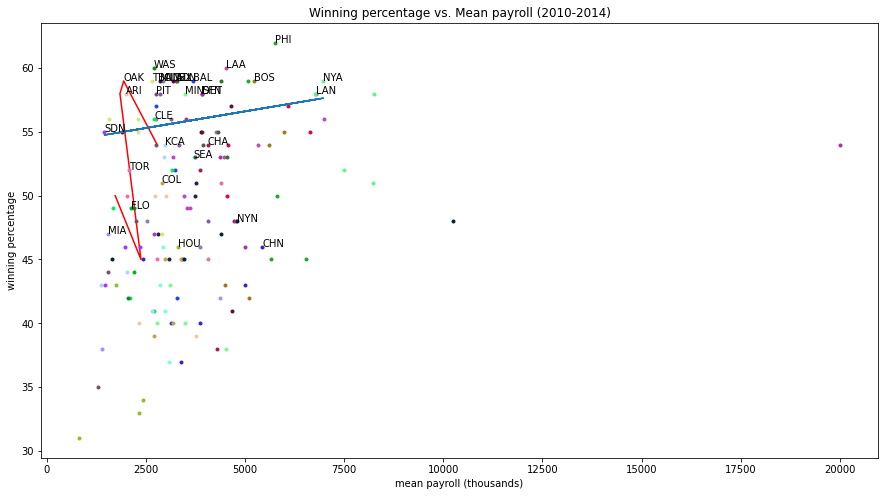

In [164]:
teams = period5['teamID'].drop_duplicates()
temp = period5[['teamID', 'win_p', 'mean_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period5.loc[lambda period5: period5.teamID == team, :]
    if t.iloc[0].win_p == t.iloc[0].win_p:
        row = t.loc[t['win_p'].idxmax()]
        plt.annotate(team, xy=(row['mean_payroll']/1000, row['win_p']))
        if team == 'OAK':
            plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '-', color='red')
        else:
            plt.plot(temp.loc[team, 'mean_payroll']/1000, temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
        x = np.append(x, [row['mean_payroll']/1000])
        y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('mean payroll (thousands)')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Mean payroll (2010-2014)')

### Question 2 (9 pts)
What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

NYA is very good at paying for wins. It is usually on the top-rightest of the scatterplot, which means lots of money and high winning rate.

To better say about OAK's efficiency, I choose to make another plot whose y-axis is winning percentage\*mean payroll and x-axis is year

Text(0.5, 1.0, "OAK's effiency though 1990-2015")

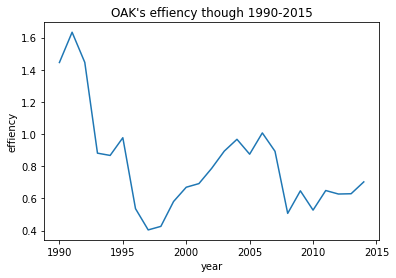

In [210]:
tableAll = table.loc[table['yearID'] >= 1990]
mean_pay = np.array([])
for year in range(1990, 2015):
    this_year = tableAll.loc[table['yearID'] == year]
    mean_pay = np.append(mean_pay, [this_year.sum(axis=0).mean_payroll/len(this_year.index)])
mean_winp = np.array([])
for year in range(1990, 2015):
    this_year = tableAll.loc[table['yearID'] == year]
    mean_winp = np.append(mean_winp, [this_year.sum(axis=0).win_p/len(this_year.index)])
    
tableOAK = table.loc[table['teamID'] == 'OAK']
tableOAK = tableOAK.loc[tableOAK['yearID'] >= 1990]
tableOAK = tableOAK.set_index('yearID')
tableOAK['average_payroll'] = mean_pay
tableOAK['average_winp'] = mean_winp
tableOAK['efficiency'] = (tableOAK['mean_payroll']*tableOAK['win_p'])/(tableOAK['average_payroll']*tableOAK['average_winp'])

plt.plot(tableOAK.index, tableOAK.efficiency)
plt.xlabel('year')
plt.ylabel('effiency')
plt.title('OAK\'s effiency though 1990-2015')

In this question, I choose to define effiency by the formula: 

OAK's (mean payroll * winning percentage)/(average payroll of all teams * average winning rate of all teams)

And by this formula, I got the above graph. This shows that the effiency of OAK dropped from around 1991 to around 1997, and went back since then to around 2006, dropped again, and slowly increase ever since. 

# Part 3: Data transformations
## Standardizing across years
It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

### Problem 5 (8 pts)
Create a new variable in your dataset that standardizes payroll conditioned on year.

In [216]:
year = 1985
payroll_list = []
payroll_avg = {}
payroll_std = {}

for index,row in payroll_table.iterrows():
    if year == row['yearID']:
        payroll_list.append(row['mean_payroll'])
    else:
        avg = statistics.mean(payroll_list)
        std = statistics.stdev(payroll_list)
        payroll_avg[year] = avg
        payroll_std[year] = std
        year = row['yearID']
        payroll_list = []
payroll_avg[year] = statistics.mean(payroll_list)
payroll_std[year] = statistics.stdev(payroll_list)

st = []
for index,row in payroll_table.iterrows():
    year = row['yearID']
    payroll = row['mean_payroll']
    st.append((payroll - payroll_avg[year])/payroll_std[year])
    
payroll_table['standardized_payroll'] = st

payroll_table

,teamID,yearID,mean_payroll,standardized_payroll
0,ATL,1985,6.730455e+05,1.946823
1,BAL,1985,5.254869e+05,0.500248
2,BOS,1985,4.359024e+05,-0.377984
3,CAL,1985,5.152819e+05,0.400205
4,CHA,1985,4.688656e+05,-0.054832
...,...,...,...,...
855,SLN,2014,4.310464e+06,-0.095956
856,TBA,2014,2.907564e+06,-0.508356
857,TEX,2014,4.677294e+06,0.011879
858,TOR,2014,4.396804e+06,-0.070575


### Problem 6 (8 pts)
Repeat the same plots as Problem 4, but use this new standardized payroll variable.

In [217]:
table = pandas.merge(payroll_table, winp_table, how='outer', on=['yearID', 'teamID'])

bins =[1989, 1994, 1999, 2004, 2009, 2014]
periods = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']
categories = pandas.cut(table['yearID'], bins, labels=periods)
table['categories'] = categories
tables = table.groupby('categories')

period1 = tables.get_group('1990-1994')
period2 = tables.get_group('1995-1999')
period3 = tables.get_group('2000-2004')
period4 = tables.get_group('2005-2009')
period5 = tables.get_group('2010-2014')

Text(0.5, 1.0, 'Winning percentage vs. Standardized payroll (1990-1994)')

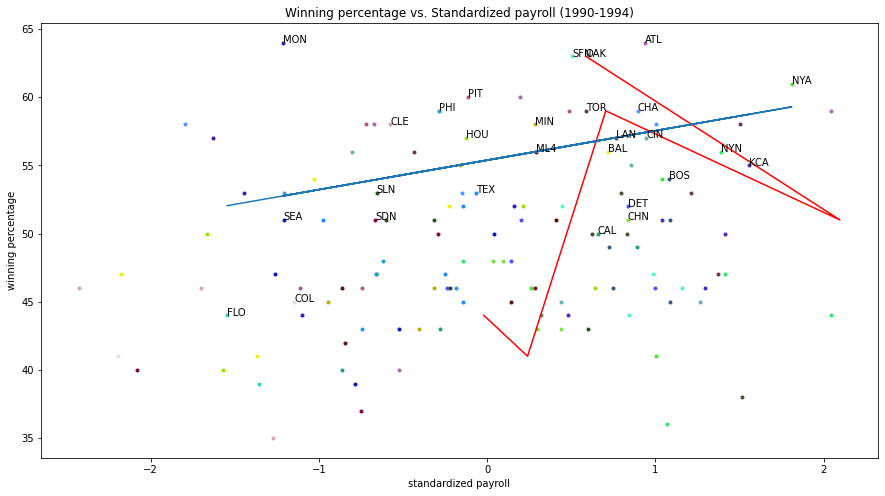

In [221]:
teams = period1['teamID'].drop_duplicates()
temp = period1[['teamID', 'win_p', 'standardized_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period1.loc[lambda period1: period1.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['standardized_payroll'], row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['standardized_payroll']])
    y = np.append(y, [row['win_p']])

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll (1990-1994)')

Text(0.5, 1.0, 'Winning percentage vs. Standardized payroll (1995-1999)')

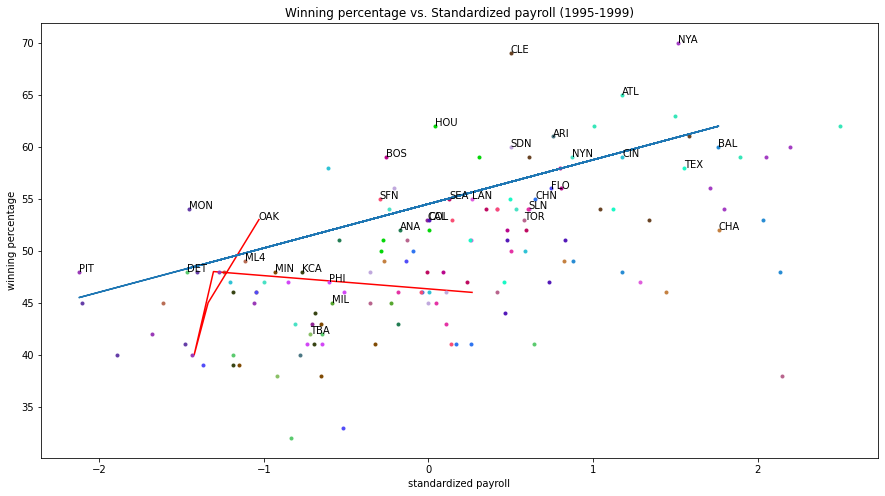

In [222]:
teams = period2['teamID'].drop_duplicates()
temp = period2[['teamID', 'win_p', 'standardized_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period2.loc[lambda period2: period2.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['standardized_payroll'], row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['standardized_payroll']])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll (1995-1999)')

Text(0.5, 1.0, 'Winning percentage vs. Standardized payroll (2000-2004)')

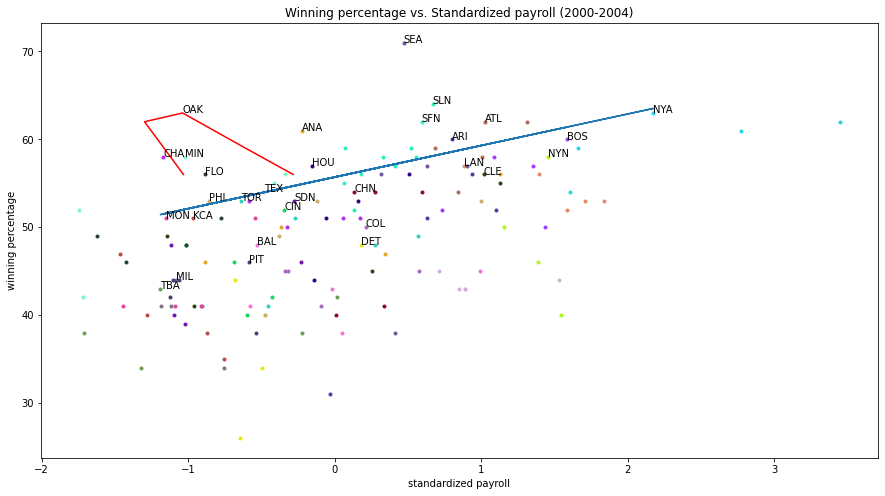

In [223]:
teams = period3['teamID'].drop_duplicates()
temp = period3[['teamID', 'win_p', 'standardized_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period3.loc[lambda period1: period1.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['standardized_payroll'], row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['standardized_payroll']])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll (2000-2004)')

Text(0.5, 1.0, 'Winning percentage vs. Standardized payroll (2005-2009)')

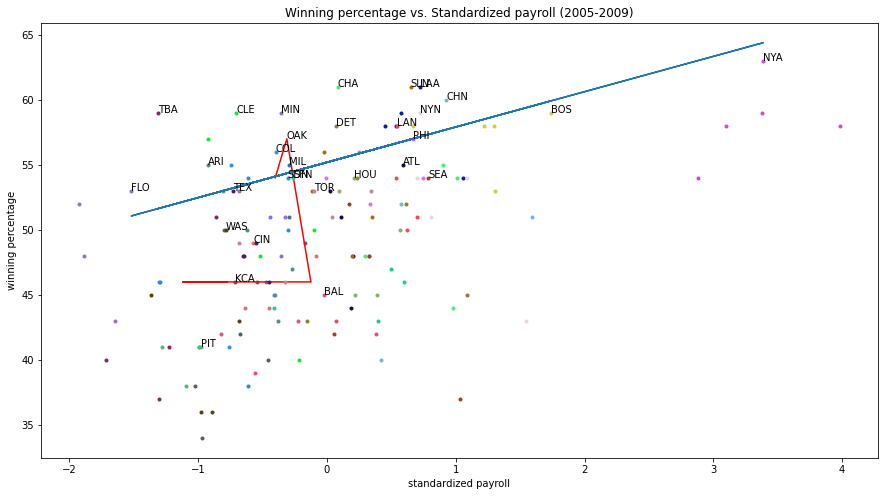

In [224]:
teams = period4['teamID'].drop_duplicates()
temp = period4[['teamID', 'win_p', 'standardized_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period4.loc[lambda period4: period4.teamID == team, :]
    row = t.loc[t['win_p'].idxmax()]
    plt.annotate(team, xy=(row['standardized_payroll'], row['win_p']))
    if team == 'OAK':
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '-', color='red')
    else:
        plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
    x = np.append(x, [row['standardized_payroll']])
    y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll (2005-2009)')

Text(0.5, 1.0, 'Winning percentage vs. Standardized payroll (2010-2014)')

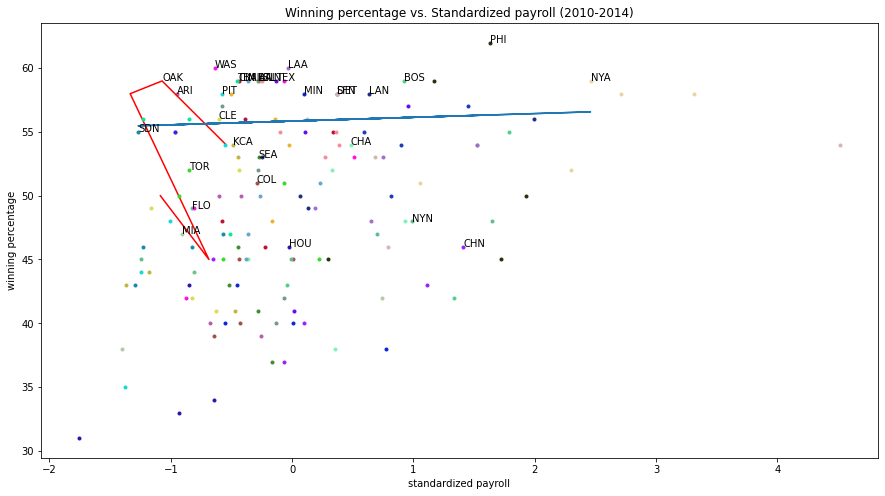

In [225]:
teams = period5['teamID'].drop_duplicates()
temp = period5[['teamID', 'win_p', 'standardized_payroll']]
temp = temp.set_index('teamID')
x = np.array([])
y = np.array([])

plt.figure(figsize=[15,8])
for team in teams:
    t = period5.loc[lambda period5: period5.teamID == team, :]
    if t.iloc[0].win_p == t.iloc[0].win_p:
        row = t.loc[t['win_p'].idxmax()]
        plt.annotate(team, xy=(row['standardized_payroll'], row['win_p']))
        if team == 'OAK':
            plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '-', color='red')
        else:
            plt.plot(temp.loc[team, 'standardized_payroll'], temp.loc[team, 'win_p'], '.', color=numpy.random.rand(3,))
        x = np.append(x, [row['standardized_payroll']])
        y = np.append(y, [row['win_p']])
    
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll (2010-2014)')

### Question 3 (9 pts)
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.

It shows a clearer distribution of the data points. For example, outliers can greatly affect how other points would distribute on the graph; by standardizing the data, the data are more like numbers of the whole field rather than a raw number that represents itself. 

## Expected wins
It's hard to see global trends across tiime periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showinig correlation between winning percentage and payroll across time.

### Problem 7 (8 pts)
Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). We will see how this is done in general using linear regression later in the course.

2.653847300480501
49.49033531448001


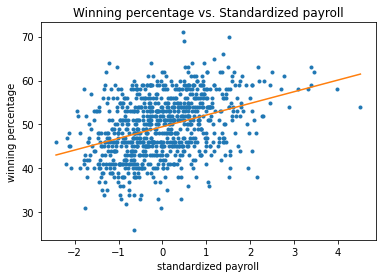

In [246]:
plt.plot(table['standardized_payroll'], table['win_p'], '.')
plt.xlabel('standardized payroll')
plt.ylabel('winning percentage')
plt.title('Winning percentage vs. Standardized payroll')

table = table[np.isfinite(table['standardized_payroll'])]
table = table[np.isfinite(table['win_p'])]

m, b = np.polyfit(table['standardized_payroll'], table['win_p'], 1)
x = np.linspace(table['standardized_payroll'].min(), table['standardized_payroll'].max(), 100)
plt.plot(x, m*x+b)
print(m)
print(b)

## Spending efficiency
Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

### Problem 8 (8 pts)
Create a new field to compute each team's spending effiency

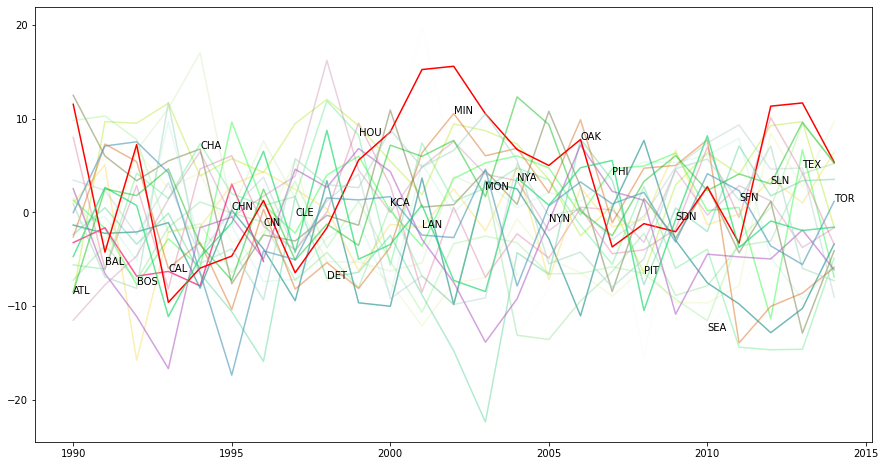

In [261]:
table['expected_win_p'] = 50 + 2.5*table['standardized_payroll']
table['efficiency'] = table['win_p'] - table['expected_win_p']
table1 = table

table1.sort_values("yearID", ascending=True)
temp = table1[table1['yearID'] > 1989]
temp = temp[temp['yearID'] < 2015]
teams = temp['teamID'].drop_duplicates()
temp = temp[['yearID', 'teamID', 'efficiency']]
temp = temp.set_index('teamID')

year = 1990
plt.figure(figsize=[15,8])
for team in teams:
    t = temp.loc[lambda temp: temp.yearID == year, :]
    if team in t.index:
        num = t.loc[team, 'efficiency']
        plt.annotate(team, xy=(year, num))
        if team == "OAK":
            plt.plot(temp.loc[team, 'yearID'], temp.loc[team, 'efficiency'], color='red')
        else:
            plt.plot(temp.loc[team, 'yearID'], temp.loc[team, 'efficiency'], color=numpy.random.rand(4,))
        
        if (year < 2014):
            year += 1
        else:
            year = 1990

### Question 4 (9 pts)
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

I would say that my "efficiency" in Question 2 is not exactly right. When it comes to comparing to the whole field, standardize by standard deviation is definitely better than using just mean. And that is actually the answer to Question 3. But comparing the graph in Question 2 and Question 4, I think that the point of changing from increasing to decreasing or otherwise is still correct, just not that "standardized".

To conclude Oakland's efficiency, I would use the graph of Problem 8.

It reached its peak around 2002, and has a unconsistent oscillation around 0 through the whold period, which means that they don't have a strategy that helps increase its effieciency through the whole time. On the other hand, the most of the plots in the whole field are actually oscillating in the similar curve, and there is rarely some teams that keeps a flat plot. I think that means there may be no such winning strategy, or means the Moneyball is an unpredicable field.

# Extra Credit (15 pts)
The data used in this project is starting to get a bit old. The extra credit is ambitious: Can you create a new sqlite database that has the newest available data (up to 2020)? Explain your method with code and prose, if your explanation is reproducible, you will get the points. In order for a method to be reproducible you must provide code that can access the data online, mangle the data as necessary and the SQL necessary for creating the new sqlite database. Use the prose to describe where you found the data and what steps might be necessary to access that data (account creation/authentication/etc.). Any steps that require human intervention should be clearly described in prose.